# Ingredients Model

This Notebook shows the process of clustering of the users according to the ingredients they use in their recipes.

It links each users with all the recipes he/she has made, then forms list of all ingredients contained in thoses recipes and computes a User/Ingredient relevance matrix using a TF-IDF approach.

The users are then projected on a 2D space by performing a Non-Negative Matrix Factorization of the Normalized User/Recipe relevance matrix followed by a t-SNE.

The users are then clustered using DBSCAN.

For the main clusters, a specificity score is computed for each ingredients. The specificity scores represents how relevant the ingredient is for a specific cluster.

Using the specificity scores of the ingredients/clusters, a similarity score is computed between the recipes and the clusters, allowing to obtain a ranked list of most similar recipes for each clusters.

In [65]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd 
import numpy as np
import pylab as pl
from scipy.sparse import lil_matrix
from util import *
%matplotlib inline

## Load recipes data

In [2]:
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    
print(recipes[:10])
print("Nb of recipes: " + str(len(recipes)))

['229804', '245348', '25093', '14930', '257743', '255991', '236394', '13148', '18454', '215435']
Nb of recipes: 44069


In [3]:
recipesDict = {}
for recipe in recipes:
    recipesDict[recipe] = True

In [4]:
recipesLinks = pd.read_csv("indexes/links.csv")
recipesNames = recipesLinks["Recipe title"]
recipesID = recipesLinks["Recipe link"].map(lambda x: x.split("/")[2])
recipesIDNames = {}

for i in range(len(recipesLinks)):
    recipesIDNames[recipesID[i]] = recipesNames[i]

## Load users data and filter user with 10+ recipes only

In [5]:
with open("data/user_data.json", "r") as in_file:
    users_data = json.load(in_file)

In [6]:
len(users_data.keys())

1017178

In [7]:
for user in users_data.keys():
    users_data[user]["made"] = list(filter(lambda x: str(x) in recipesDict, users_data[user]["made"]))

In [8]:
users_data = {k: v for k, v in users_data.items() if len(v["made"]) > 30 and len(v["made"]) < 200}
users = list(users_data.keys())

In [9]:
len(users_data.keys())

16758

## Link recipes and ingredients

In [10]:
def getIngredientList(recipe):
    with open("recipe_data/" + recipe + "/data.json", "r") as input_file:
        data = json.load(input_file)
    return data["ingredients"]

In [11]:
recipeIngredients = {}
for recipe in recipes:
    recipeIngredients[recipe] = getIngredientList(recipe)

In [12]:
ingredientIDText = {}

for recipe in recipes:
    for ingredient in recipeIngredients[recipe]:
        if ingredient["id"] not in ingredientIDText:
            ingredientIDText[ingredient["id"]] = ingredient["text"]

In [13]:
len(ingredientIDText.items())

6479

In [14]:
len(ingredientIDText.keys())

6479

In [15]:
ingredientIdx, ingredientUnique = pd.factorize(list(ingredientIDText.keys()))
ingredientDict = {}
for i in range(len(ingredientUnique)):
    if ingredientUnique[i] in ingredientDict:
        print("Problem with " + str(ingredientUnique[i]))
    else:
        ingredientDict[ingredientUnique[i]] = i 

In [16]:
userIdx, userUnique = pd.factorize(users)

# TF/IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
def getUsersIngredients(recipes):
    ingredients = []
    for recipe in recipes:
        for ingredient in recipeIngredients[str(recipe)]:
            ingredients.append(ingredient["id"])
    return " ".join(ingredients)

In [21]:
usersDF = pd.DataFrame(users)
usersDF.columns = ["user"]
usersDF["recipes"] = usersDF["user"].map(lambda x: users_data[x]["made"])
usersDF["ingredients"] = usersDF["recipes"].map(lambda x: getUsersIngredients(x))

In [22]:
usersDF.head()

,user,recipes,ingredients
0,973722,"[8854, 77981, 61024, 23567, 8758, 26317, 16198...",4252 6549 615 16278 16215 16157 2112 16157 439...
1,1312442,"[8941, 8665, 11864, 139340, 80285, 11843, 1419...",6494 16157 5467 4397 2061 6494 18740 16406 630...
2,269580,"[77981, 12072, 67952, 54675, 21766, 141678, 58...",16157 4397 4292 4279 4442 4537 16133 16421 176...
3,3715648,"[142434, 221239, 12942, 176287, 25112, 11458, ...",4808 16278 1525 16386 10643 3717 2882 16396 51...
4,1168774,"[6737, 69384, 23094, 70749, 42719, 9615, 7458,...",2362 1525 16421 2496 1684 1686 2496 2359 16157...


In [23]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5)
X = vectorizer.fit_transform(usersDF["ingredients"])
X.shape

(16758, 3474)

In [24]:
ingredientsMap = vectorizer.get_feature_names()    
reverseIngredientsMap = {}
for i in range(len(ingredientsMap)):
    reverseIngredientsMap[ingredientsMap[i]] = i

In [25]:
Xraw = X

## Clustering

In [26]:
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

X_normalized = Xraw
X_normalized = preprocessing.normalize(X_normalized,'l1')
X_normalized.shape

model = NMF(n_components=10, init='random',random_state=0)
W = model.fit_transform(X_normalized)
H = model.components_

digits_proj = TSNE(n_components=2, verbose=2).fit_transform(W)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16758 samples in 0.015s...
[t-SNE] Computed neighbors for 16758 samples in 5.863s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16758
[t-SNE] Computed conditional probabilities for sample 2000 / 16758
[t-SNE] Computed conditional probabilities for sample 3000 / 16758
[t-SNE] Computed conditional probabilities for sample 4000 / 16758
[t-SNE] Computed conditional probabilities for sample 5000 / 16758
[t-SNE] Computed conditional probabilities for sample 6000 / 16758
[t-SNE] Computed conditional probabilities for sample 7000 / 16758
[t-SNE] Computed conditional probabilities for sample 8000 / 16758
[t-SNE] Computed conditional probabilities for sample 9000 / 16758
[t-SNE] Computed conditional probabilities for sample 10000 / 16758
[t-SNE] Computed conditional probabilities for sample 11000 / 16758
[t-SNE] Computed conditional probabilities for sample 12000 / 16758
[t-SNE] Computed conditional probabilities for sam

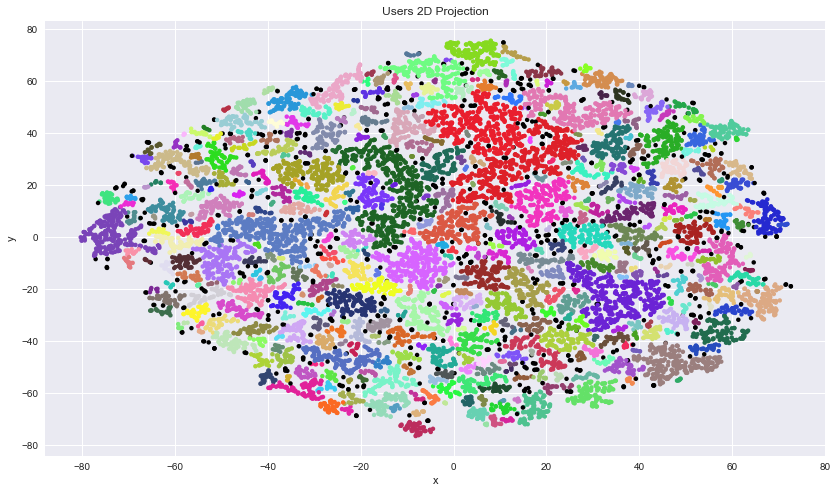

In [114]:
# plotting
def set_colors(labels, colors=None):
    import random
    r = lambda: random.randint(30,255)
    if colors is None:
        colors = 'mrgybc'*1000 + "k"
        colors = []
        for i in range(len(labels)-1):
            colors.append('#%02X%02X%02X' % (r(),r(),r()))
        colors.append('#000000')
    colored_labels = []
    for label in labels:
        colored_labels.append(colors[label])
    return colored_labels

# Fit a DBSCAN estimator
estimator = DBSCAN(eps=1.3, min_samples=5)
estimator.fit(digits_proj)
# Clusters are given in the labels_ attribute
labels = estimator.labels_

colors = set_colors(labels)
fig = plt.gcf()
fig.set_size_inches(14, 8)
ax = plt.scatter(digits_proj[:,0], digits_proj[:,1], lw=0, s=20, c=colors)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Users 2D Projection")
plt.show()

In [41]:
from collections import Counter
feat_names = np.array(vectorizer.get_feature_names())
label_cnt = Counter(labels)

In [42]:
label_cnt[1] = 0
filtered_labels = list(filter(lambda x: x[0] != -1, label_cnt.most_common()))
filtered_labels = filtered_labels[0:10]
filtered_labels

[(0, 514),
 (72, 488),
 (6, 424),
 (26, 420),
 (2, 290),
 (132, 267),
 (17, 259),
 (66, 259),
 (101, 215),
 (22, 209)]

## Computing ingredients specificity

the specificity score $ S_{ci} $ of ingredient $i$ for cluster $c$ is computed as follow:

$$ S_{ci} = p_{ci} - p_{ji} $$
 
where:
* $ p_{ci} $ is the frequency of ingredient $i$ in cluster $c$
* $ p_{ji} $ is the frequency of ingredient $i$ in all users except those in cluster $c$

In [43]:
specificity_scores = np.zeros((len(filtered_labels), X_normalized.shape[1]))

for i in range(len(filtered_labels)):
    label = filtered_labels[i][0]
        
    distrib_pos = X_normalized[labels==label,:].sum(axis=0)
    distrib_neg = X_normalized[labels!=label,:].sum(axis=0)

    # normalize
    distrib_pos = distrib_pos / distrib_pos.sum()
    distrib_neg = distrib_neg / distrib_neg.sum()
    
    specificity_scores[i] = (distrib_pos - distrib_neg)
    
    distrib_pos = np.array(distrib_pos)[0]
    distrib_neg = np.array(distrib_neg)[0]
    
    print("CLUSTER: ", label, "-"*40 )
    for feat_idx in specificity_scores[i].argsort()[::-1][:10]:
        ingredient_name = ingredientIDText[feat_names[feat_idx]]
        print("-- ", ingredient_name ,specificity_scores[i][feat_idx], distrib_pos[feat_idx], distrib_neg[feat_idx])

CLUSTER:  0 ----------------------------------------
--  1 (4 ounce) can chopped green chiles (such as Old El Paso®) 0.00283344597109 0.00605118840099 0.0032177424299
--  1 1/2 cups shredded Monterey Jack cheese 0.00257530083546 0.00594295467255 0.00336765383709
--  1 tablespoon taco seasoning mix (such as Old El Paso®) 0.00222520003237 0.00496464297026 0.00273944293789
--  2 (6 ounce) cans black olives, drained 0.00219649698152 0.00511497078792 0.00291847380639
--  1 (28 ounce) can diced tomatoes with green chile peppers (such as RO*TEL®) 0.00183215461412 0.00389369032753 0.00206153571341
--  1 (16 ounce) can whole kernel corn, drained 0.00170975776619 0.00481208135333 0.00310232358715
--  1/2 head iceberg lettuce - rinsed, dried, and chopped 0.001699781103 0.00354388357909 0.00184410247609
--  1 (15 ounce) can black beans, rinsed 0.0016542917638 0.00477412010085 0.00311982833705
--  1 (12 ounce) package corn tortillas 0.00161224804822 0.00363648706067 0.00202423901245
--  3 tablespoo

## Computing similarity between clusters and recipes

To compute the similarity score between a recipe and a cluster, we compute the average specificity of the ingredients of the recipe for the cluster:

$$ S_{CR} = \frac{1}{|R|} \sum_{i \in R} s_{ci} $$

In [44]:
recipeIngredientsList = {}
for recipe in recipeIngredients:
    recipeIngredientsList[recipe] = list(map(lambda x: x["id"],recipeIngredients[recipe]))

In [45]:
def computeRecipesSimilarity(recipe, cluster_index):
    ingredients = recipeIngredientsList[recipe]
    
    similarity = np.array(list(map(lambda x: specificity_scores[cluster_index][reverseIngredientsMap[x]], filter(lambda x: x in reverseIngredientsMap, ingredients)))).mean()
    return similarity

In [46]:
recipesClusterDF = pd.DataFrame()
for i in range(len(filtered_labels)):
    cluster = filtered_labels[i][0]
    recipesClusterDF[cluster] = list(map(lambda x: computeRecipesSimilarity(x, i), recipes))

/home/nathan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice.
/home/nathan/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
list(filter(lambda x: x in reverseIngredientsMap, recipeIngredientsList[recipes[0]]))

[]

In [48]:
recipeIngredients[recipes[0]]

[{'id': '6300', 'text': '1 cup vegetable shortening'},
 {'id': '1526', 'text': '1 cup white sugar'},
 {'id': '16278', 'text': '1/4 cup milk'},
 {'id': '16317', 'text': '2 eggs'},
 {'id': '16424', 'text': '1 teaspoon vanilla extract'},
 {'id': '1684', 'text': '3 cups all-purpose flour'},
 {'id': '16421', 'text': '1 teaspoon salt'},
 {'id': '2359', 'text': '1 teaspoon baking soda'},
 {'id': '16157', 'text': '1/4 cup butter'},
 {'id': '1527', 'text': "3 cups confectioners' sugar"},
 {'id': '16424', 'text': '1 1/2 teaspoons vanilla extract, or more to taste'},
 {'id': '16278', 'text': '2 tablespoons milk, or as needed'}]

In [49]:
clustersOrderedRecipesDF = pd.DataFrame()
for cluster in recipesClusterDF:
    clustersOrderedRecipesDF[cluster] = list(map(lambda x: recipes[x], recipesClusterDF.sort_values([cluster], ascending=False)[cluster].index))

In [50]:
clustersOrderedRecipesDF.head()

,0,72,6,26,2,132,17,66,101,22
0,163703,76942,70048,211466,231066,106184,213948,6996,244453,241580
1,245961,177115,242456,24381,255931,11804,85132,234424,86374,256351
2,14855,233408,6758,220522,233281,8617,211466,257199,258232,229159
3,21660,50648,7138,85132,247061,8867,256207,235292,38410,141933
4,247375,229776,7065,25907,234939,228409,25907,70048,16993,159632


In [51]:
clustersOrderedRecipesTitleDF = pd.DataFrame()
for cluster in clustersOrderedRecipesDF:
    clustersOrderedRecipesTitleDF[cluster] = clustersOrderedRecipesDF[cluster].map(lambda x: recipesIDNames[x])

In [52]:
clustersOrderedRecipesTitleDF.head(10)

,0,72,6,26,2,132,17,66,101,22
0,Green Chili Eggs,Oregano-Flavored Feta,Simple and Tasty Chinese Steamed Buns,Chicken with Ginger Pesto,Blue Ribbon Apple Crumb Pie,Simple Creamy Lemon Chicken Sauce,Poached Eggs in Ginger Syrup,Cinnamon Rolls II,Canadian Flag Cake,Cranberry Lemon Scones
1,White Bean Chicken Chili from Knorr®,Feta-Stuffed Hamburgers,Breadsticks,Japanese Ginger Salad Dressing,Baked Cinnamon Apples,Mushroom Sauce,Ginger Garlic Paste,"How to Make Cronuts, Part I",Strawberry Cream Cheese Spread,Banana Walnut Cranberry Muffins
2,Suzy's Potato Skins,Quickie Kajmak,Unbelievable Rolls,Hearty Irish Egg Drop Soup,Apple Chips,Creamy Chicken,Chicken with Ginger Pesto,Thin Crust Pizza Dough,Cookie Crumb Chocolate Covered Strawberry,Dried Bloody Scabs (Halloween Craisin® Appetizer)
3,Chile Cheese Squares,Feta Eggs,Southern Butter Rolls,Ginger Garlic Paste,Coconut Minis Vanilla Sandwich Cake,Sour Cream Chicken,Cauliflower Fried Rice,Parker House Rolls,Strawberry Jam,Banana-Zucchini Bread
4,Jan's Chile Con Queso,Stuffed Zucchini Shells,French Herb Bread,Buttered Ginger Sauce,Strawberry Soda Syrup,Knoepfla Soup,Buttered Ginger Sauce,Simple and Tasty Chinese Steamed Buns,Strawberry Pizza,Baked Stuffed Apple
5,My Favorite Mexican Rice,Egg Muffins,Cheddar Rolls,"Sweet, Sticky and Spicy Chicken",Double Berry Brownie Yogurt Cup,Sour Cream Mushroom Chicken,Hot and Sweet Ginger Drink,Sourdough Starter,Strawberry Apple Baby Food,Spinach and Bacon Chicken
6,Mushroom Stuffed Zucchini,Simplistic Pepper Salad,Butter Crescents,"Warm Lemon, Honey, and Ginger Soother",Valentine Night Strawberries,Easy Sour Cream Scalloped Potatoes,Honey Garlic Sauce,Placek,Strawberries and Cream,Spinach Saute
7,Caitlin's Mexican Rice,Crustless Spinach and Mushroom Quiche,Snail Pale,Hot and Sweet Ginger Drink,Strawberry Jam,Saucy Chicken Dip,Crystallized or Candied Ginger,Yeast Dumplings,Double Berry Brownie Yogurt Cup,Spinach Brownies
8,Rice With Olives And Green Chile Peppers,Chef John's Spinach and Feta Pie,Buttery Pan Rolls,Fish and Things Teriyaki Marinade,Cheesecake Fruit Dip from Reddi-wip®,Potatoes Supreme,Itsmeatshuddupneatit,Cream Cheese Danish Coffeecake,One-Ingredient Sorbet,Baked Spinach
9,Beth's Tex Mex Dip,Classic Deviled Eggs,Breakfast Bread,Cauliflower Fried Rice,Strawberry Nut Bread,Pork Chop and Cheesy Rice Casserole,Gingeradish,Sunday Dinner Rolls,Aunt Kate's Strawberry Cake,Lisa's 1-Skillet Chicken


## Evaluating Recipes HealthScore in Clusters

In [63]:
recipeHealthPopularity = pd.read_csv("data/HealthPopularity.csv")

In [96]:
ClusterHealthScores = pd.DataFrame()

mexicanClusterHealthScores = []
for recipe_id in clustersOrderedRecipesDF[0].head(100):
    with open('recipe_data/' + recipe_id + "/healthscore.json", 'r') as infile:
        mexicanClusterHealthScores.append(json.load(infile)["score"])
ClusterHealthScores["Mexican"] = mexicanClusterHealthScores

asianClusterHealthScores = []
for recipe_id in clustersOrderedRecipesDF[26].head(100):
    with open('recipe_data/' + recipe_id + "/healthscore.json", 'r') as infile:
        asianClusterHealthScores.append(json.load(infile)["score"])
ClusterHealthScores["Asian"] = asianClusterHealthScores

sauceClusterHealthScores = []
for recipe_id in clustersOrderedRecipesDF[132].head(100):
    with open('recipe_data/' + recipe_id + "/healthscore.json", 'r') as infile:
        sauceClusterHealthScores.append(json.load(infile)["score"])
ClusterHealthScores["Sauce"] = sauceClusterHealthScores

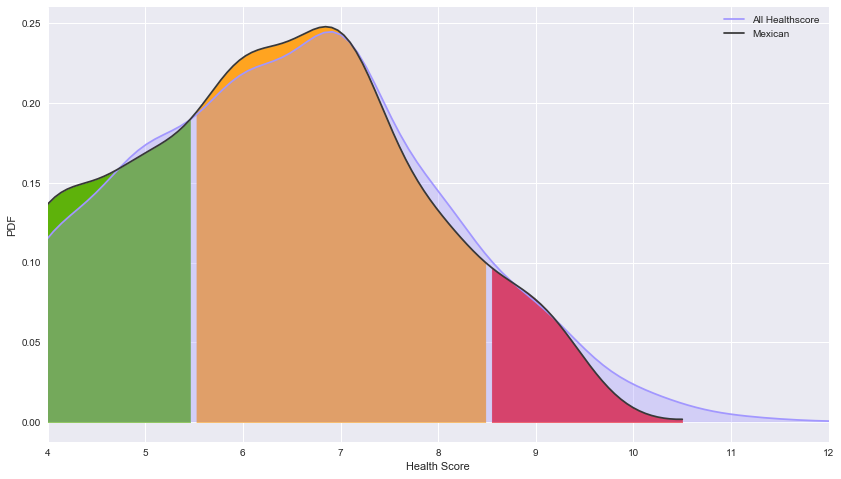

In [104]:
allHealthScore = recipeHealthPopularity["HealthScore"]
allHealthScore.name = "All Healthscore"
plotHealthHistogram([ClusterHealthScores[ClusterHealthScores["Mexican"]>=4]["Mexican"], allHealthScore])

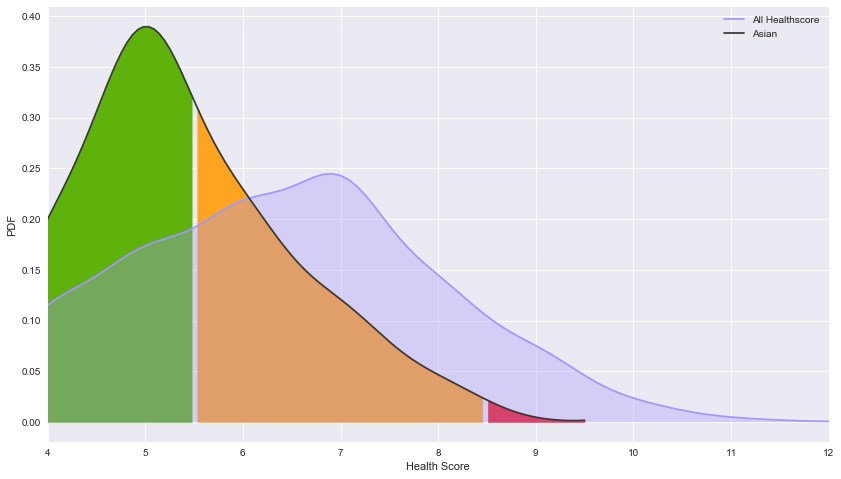

In [105]:
allHealthScore = recipeHealthPopularity["HealthScore"]
allHealthScore.name = "All Healthscore"
plotHealthHistogram([ClusterHealthScores[ClusterHealthScores["Asian"]>=4]["Asian"], allHealthScore])

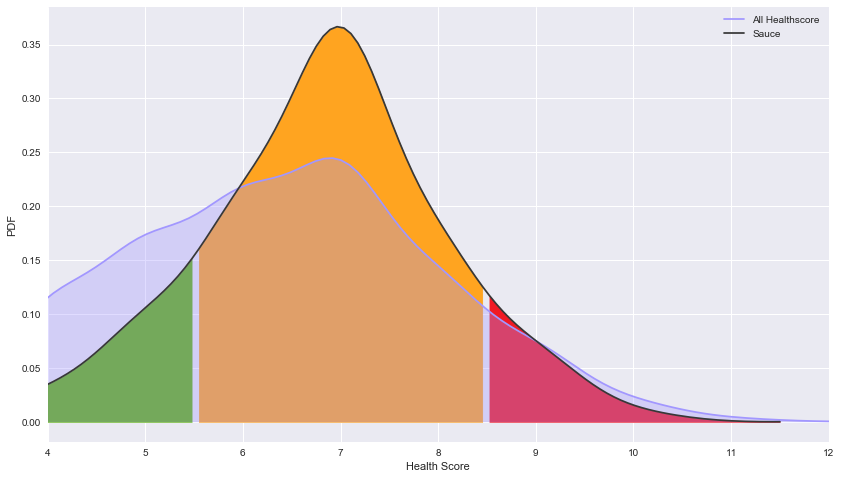

In [106]:
allHealthScore = recipeHealthPopularity["HealthScore"]
allHealthScore.name = "All Healthscore"
plotHealthHistogram([ClusterHealthScores[ClusterHealthScores["Sauce"] >= 4]["Sauce"], allHealthScore])